In [2]:
import os
import sys 
import skimage
from skimage import transform, io, img_as_float32, img_as_uint
from staintools import ReinhardNormalizer,VahadaneNormalizer,MacenkoNormalizer
from staintools.utils.visual import patch_grid, build_stack
import glob
from sklearn.model_selection import train_test_split
import numpy as np
import torch

In [3]:
import torch # work as numpy here
import torch.autograd as autograd # builds computational graph  
import torch.nn as nn # neural net library
import torch.nn.functional as F # all the non linearities
import torch.optim as optim # optimization package

In [4]:
from Unet import Unet

In [5]:
# read images from dir
TRAIN_DIR = './train-img284x284/'
train_imgs = []
for filename in glob.glob(TRAIN_DIR+'/*.png'):
    train_imgs.append(img_as_float32(io.imread(filename)))

In [6]:
MASK_DIR = './train-maskbin284x284/'
train_masks = []
for filename in glob.glob(MASK_DIR+'/*.png'):
    train_masks.append(img_as_float32(io.imread(filename)))

In [7]:
train_masks[0].shape


IndexError: list index out of range

In [8]:
len(train_masks)

0

In [7]:
def dice_loss(input,target):
    """
    input is a torch variable of size BatchxnclassesxHxW representing log probabilities for each class
    target is a 1-hot representation of the groundtruth, shoud have same size as the input
    """
    assert input.size() == target.size(), "Input sizes must be equal."
    assert input.dim() == 4, "Input must be a 4D Tensor."
    uniques=np.unique(target.numpy())
    assert set(list(uniques))<=set([0,1]), "target must only contain zeros and ones"

    probs=F.softmax(input)
    num=probs*target#b,c,h,w--p*g
    num=torch.sum(num,dim=3)#b,c,h
    num=torch.sum(num,dim=2)
    

    den1=probs*probs#--p^2
    den1=torch.sum(den1,dim=3)#b,c,h
    den1=torch.sum(den1,dim=2)
    

    den2=target*target#--g^2
    den2=torch.sum(den2,dim=3)#b,c,h
    den2=torch.sum(den2,dim=2)#b,c
    

    dice=2*(num/(den1+den2))
    dice_eso=dice[:,1:]#we ignore bg dice val, and take the fg

    dice_total=-1*torch.sum(dice_eso)/dice_eso.size(0)#divide by batch_sz

    return dice_total

In [8]:
def batch(iterable1,batch_size):
    """Yields lists by batch"""
    b = []
    for i, t in enumerate(iterable):
        b.append(t)
        if (i + 1) % batch_size == 0:
            yield b
            b = []

    if len(b) > 0:
        yield b

In [9]:
def batch_costum(X,Y,batch_size):
    yield batch(X,batch_size), batch(Y,batch_size)

In [10]:
def train_net(net,X,Y,epochs=5,batch_size=1,lr=0.1,val_ratio=0.1):
    X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=val_ratio)
    
    N_train = len(X_train)
    
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
    
    criterion = dice_loss()
    print('''
    Starting training:
        Epochs: {}
        Batch size: {}
        Learning rate: {}
        Training size: {}
        Validation size: {}
    '''.format(epochs, batch_size, lr, N_train,
               len(X_val)))
    for epoch in range(0,epochs):
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
        
        epoch_loss = 0
        
        for i,imgs,t_masks in enumerate(batch_custum(X_train,Y_train,batch_size)):
            
            imgs = torch.from_numpy(imgs)
            t_masks = torch.from_numpy(t_masks)
            
            p_masks = net(imgs)
            
            loss = criterion(p_masks,t_masks)
            epoch_loss += loss
            
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train , loss.item()))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print('Epoch finished ! Loss: {}'.format(epoch_loss))
        
        val_dice = criterion(net(X_val),Y_val)
        print('Validation Dice Coeff: {}'.format(val_dice))

In [11]:
net = Unet(n_ch=3,n_classes=1)

In [51]:
test = np.array(train_imgs)
print(test.shape)
test = np.moveaxis(test,3,1)
print(test.shape)

(188, 284, 284, 3)
(188, 3, 284, 284)


(1, 284, 284, 3)
(1, 3, 284, 284)


In [15]:
out = net(torch.from_numpy(imgs))

torch.Size([1, 256, 71, 71]) torch.Size([1, 256, 71, 71])
torch.Size([1, 128, 142, 142]) torch.Size([1, 128, 142, 142])
torch.Size([1, 64, 284, 284]) torch.Size([1, 64, 284, 284])


In [16]:
out.shape

torch.Size([1, 1, 284, 284])

In [17]:
msks = train_masks[1:2]

In [30]:
test = [msks[0].reshape((1,284,284))]

In [34]:
test = np.array(test)

In [35]:
test.shape

(1, 1, 284, 284)

In [36]:
out.shape

torch.Size([1, 1, 284, 284])

In [37]:
torch.from_numpy(test).shape

torch.Size([1, 1, 284, 284])

In [41]:
loss = dice_loss(out,torch.from_numpy(test))

/home/shiva/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [44]:
loss

tensor(1.00000e-41 *
       -4.5696)

In [45]:
out = np.moveaxis(out.detach().numpy(), 1,3)
print(out.shape)

(1, 284, 284, 1)


array(-4.5696e-41, dtype=float32)

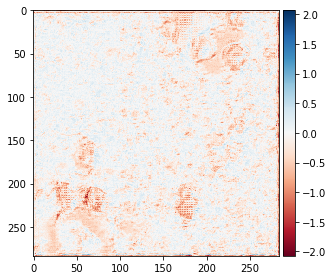

In [48]:
io.imshow(out[0].reshape((284,284)))